# Prediciting your Future order!
> This notebook is implementing a predictive analysis model, that predicts the products ordered in users' future order based on each purchasing history.

## Model Usage
> **How this model will make better customer shopping expireince?**

> Customers tend to do things quick and in an easy way. Thus can integrate this model with instacart's shopping software to initially autofill user's basket once openned the application.

## 1. Reading Data

In [26]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# garbage collector to free up memory
import gc
gc.enable()

In [27]:
orders = pd.read_csv('/kaggle/input/d/datasets/psparks/instacart-market-basket-analysis/orders.csv' )
order_products_train = pd.read_csv('/kaggle/input/d/datasets/psparks/instacart-market-basket-analysis/order_products__train.csv')
order_products_prior = pd.read_csv('/kaggle/input/d/datasets/psparks/instacart-market-basket-analysis/order_products__prior.csv')
products = pd.read_csv('/kaggle/input/d/datasets/psparks/instacart-market-basket-analysis/products.csv')
aisles = pd.read_csv('/kaggle/input/d/datasets/psparks/instacart-market-basket-analysis/aisles.csv')
departments = pd.read_csv('/kaggle/input/d/datasets/psparks/instacart-market-basket-analysis/departments.csv')

In [28]:
def reduce_mem_usage(train_data):
    
#  iterate through all the columns of a dataframe and modify the data type to reduce memory usage."""
    start_mem = train_data.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in train_data.columns:
        col_type = train_data[col].dtype

        if col_type != object:
            c_min = train_data[col].min()
            c_max = train_data[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    train_data[col] = train_data[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    train_data[col] = train_data[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    train_data[col] = train_data[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    train_data[col] = train_data[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    train_data[col] = train_data[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    train_data[col] = train_data[col].astype(np.float32)
                else:
                    train_data[col] = train_data[col].astype(np.float64)
        else:
            train_data[col] = train_data[col].astype('category')
        end_mem = train_data.memory_usage().sum() / 1024**2
        print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return train_data

In [29]:
reduce_mem_usage(order_products_prior)
reduce_mem_usage(order_products_train)
reduce_mem_usage(products)
reduce_mem_usage(orders)
reduce_mem_usage(departments)
reduce_mem_usage(aisles)

Memory usage of dataframe is 989.82 MB
Memory usage after optimization is: 866.09 MB
Decreased by 12.5%
Memory usage after optimization is: 742.37 MB
Decreased by 25.0%
Memory usage after optimization is: 556.78 MB
Decreased by 43.7%
Memory usage after optimization is: 340.25 MB
Decreased by 65.6%
Memory usage of dataframe is 42.26 MB
Memory usage after optimization is: 36.97 MB
Decreased by 12.5%
Memory usage after optimization is: 31.69 MB
Decreased by 25.0%
Memory usage after optimization is: 22.45 MB
Decreased by 46.9%
Memory usage after optimization is: 13.20 MB
Decreased by 68.7%
Memory usage of dataframe is 1.52 MB
Memory usage after optimization is: 1.33 MB
Decreased by 12.5%
Memory usage after optimization is: 2.52 MB
Decreased by -66.5%
Memory usage after optimization is: 2.24 MB
Decreased by -47.7%
Memory usage after optimization is: 1.91 MB
Decreased by -25.8%
Memory usage of dataframe is 182.71 MB
Memory usage after optimization is: 169.66 MB
Decreased by 7.1%
Memory usage

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation
...,...,...
129,130,hot cereal pancake mixes
130,131,dry pasta
131,132,beauty
132,133,muscles joints pain relief


In [30]:
# get shape of each df
print(f" aisles : {aisles.shape} \n depts : {departments.shape} \n order_prod_prior : {order_products_prior.shape} \n order_products_train : {order_products_train.shape} \n orders : {orders.shape} \n products : {products.shape}")

 aisles : (134, 2) 
 depts : (21, 2) 
 order_prod_prior : (32434489, 4) 
 order_products_train : (1384617, 4) 
 orders : (3421083, 7) 
 products : (49688, 4)


In [31]:
# Helper functions to be able to correclty calculate the avergae of hours
# The problem is that if we deal with hours and average them normally, the average of 1:00 and 23:00 will be 12 not 0:00
import datetime
import math

def datetime_to_radians(x):
    # radians are calculated using a 24-hour circle, not 12-hour, starting at north and moving clockwise
    seconds_from_midnight = 3600 * x
    radians = float(seconds_from_midnight) / float(12 * 60 * 60) * 2.0 * math.pi
    return radians

def average_angle(angles):
    # angles measured in radians
    x_sum = np.sum(np.sin(angles))
    y_sum = np.sum(np.cos(angles))
    x_mean = x_sum / float(len(angles))
    y_mean = y_sum / float(len(angles))
    return np.arctan2(x_mean, y_mean)

def radians_to_time_of_day(x):
    # radians are measured clockwise from north and represent time in a 24-hour circle
    seconds_from_midnight = int(float(x) / (2.0 * math.pi) * 12.0 * 60.0 * 60.0)
    hour = seconds_from_midnight // 3600 % 24
    minute = (seconds_from_midnight % 3600) // 60
    second = seconds_from_midnight % 60
    return datetime.time(hour, minute, second)
    
def average_times_of_day(x):
    # input datetime.datetime array and output datetime.time value
    angles = [datetime_to_radians(y) for y in x]
    avg_angle = average_angle(angles)
    return radians_to_time_of_day(avg_angle)

def day_to_radians(day):
    radians = float(day) / float(7) * 2.0 * math.pi
    return radians
def radians_to_days(x):
    day = int(float(x) / (2.0 * math.pi) * 7) % 7
    return day
def average_days(x):
    angles = [day_to_radians(y) for y in x]
    avg_angle = average_angle(angles)
    return radians_to_days(avg_angle)

## 2. Predictor Features

### 2.1 User predictors


In [32]:
# We keep only the prior orders
users = orders[orders['eval_set'] == 'prior']
users['days_since_prior_order'].dropna()

# We group orders by user_id & calculate the variables based on different user_id
users = users.groupby('user_id').agg(
    
 user_orders= ('order_number' , max),
 user_period=('days_since_prior_order', sum),
 user_mean_days_since_prior = ('days_since_prior_order','mean')
    
)
users.head()

,user_orders,user_period,user_mean_days_since_prior
user_id,,,
1,10,176.0,19.562500
2,14,198.0,15.234375
3,12,133.0,12.093750
4,5,55.0,13.750000
5,4,40.0,13.335938


#### calculate three more new variables:

user_total_products: Total numbers of basket items included in user's orders

user_reorder_ratio: Ratio a user orders reorordered products.

user_distinct_products: Total number of distinct products ordered by a user

In [33]:
# We create a new table "orders_products" which contains the tables "orders" and "order_products_prior"
orders_products =pd.merge(orders , order_products_prior, on='order_id', how='inner')

# Getting the number of products in each basket(order)
groupedorders_products = orders_products.groupby(['order_id']).agg(
    basket_size = ('product_id', 'count')
).reset_index()
orders_products = orders_products.merge(groupedorders_products, on='order_id', how='left')
orders_products.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,basket_size
0,2539329,1,prior,1,2,8,NaN,196,1,0,5
1,2539329,1,prior,1,2,8,NaN,14084,2,0,5
2,2539329,1,prior,1,2,8,NaN,12427,3,0,5
3,2539329,1,prior,1,2,8,NaN,26088,4,0,5
4,2539329,1,prior,1,2,8,NaN,26405,5,0,5


In [34]:
orders_products['p_reordered']= orders_products['reordered']==1
orders_products['non_first_order']= orders_products['order_number']>1

us=orders_products

# We group orders_products by user_id & calculate the variables based on different user_id
us=orders_products.groupby('user_id').agg(
    
     user_total_products =('user_id','count') ,
     p_reordered =('p_reordered', sum) ,
     non_first_order =('non_first_order', sum),
     user_distinct_products=('product_id','nunique')

).reset_index()
#    us['user_reorder_ratio'] = sum(reordered == 1) / sum(order_number > 1)
us['user_reorder_ratio']=us['p_reordered']/us['non_first_order']

del us["p_reordered"],us["non_first_order"]
del orders_products['p_reordered' ],orders_products['non_first_order']

us.head(20)

,user_id,user_total_products,user_distinct_products,user_reorder_ratio
0,1,59,18,0.759259
1,2,195,102,0.510989
2,3,88,33,0.705128
3,4,18,17,0.071429
4,5,37,23,0.538462
5,6,14,12,0.200000
6,7,206,68,0.711340
7,8,49,36,0.464286
8,9,76,58,0.391304
9,10,143,94,0.355072


#### Then we combine the users and us tables ussing inner_join() function and we calculate the final variable:

user_average_basket: Average number of basket items per order per user

In [35]:
users =pd.merge(users,us ,on='user_id',  how='inner')

# We calculate the user_average_basket variable
users['user_average_basket'] = users['user_total_products'] / users['user_orders']
users.head()

,user_id,user_orders,user_period,user_mean_days_since_prior,user_total_products,user_distinct_products,user_reorder_ratio,user_average_basket
0,1,10,176.0,19.562500,59,18,0.759259,5.900000
1,2,14,198.0,15.234375,195,102,0.510989,13.928571
2,3,12,133.0,12.093750,88,33,0.705128,7.333333
3,4,5,55.0,13.750000,18,17,0.071429,3.600000
4,5,4,40.0,13.335938,37,23,0.538462,9.250000


We now identify the future order per user and add them in the users table. The future orders are indicated as train and test in the eval_set variable. As a result, we will know what is the order_id of the future order per user, whether this order belongs in the train or test set, and the time in days since the last order.

In [36]:
# we exclude prior orders and thus we keep only train and test orders
us = orders[orders['eval_set'] != 'prior']
us['time_since_last_order'] = us['days_since_prior_order']
us['future_order_dow'] = us['order_dow']
us['future_order_hour_of_day'] = us['order_hour_of_day']

us = us[['user_id','order_id','eval_set','time_since_last_order', 'future_order_dow', 'future_order_hour_of_day']]

# We combine users and us tables and store the results into the users table
users_features = pd.merge(users , us, on='user_id', how='inner') 

# We delete the us table
del us, users

users_features.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

,user_id,user_orders,user_period,user_mean_days_since_prior,user_total_products,user_distinct_products,user_reorder_ratio,user_average_basket,order_id,eval_set,time_since_last_order,future_order_dow,future_order_hour_of_day
0,1,10,176.0,19.562500,59,18,0.759259,5.900000,1187899,train,14.0,4,8
1,2,14,198.0,15.234375,195,102,0.510989,13.928571,1492625,train,30.0,1,11
2,3,12,133.0,12.093750,88,33,0.705128,7.333333,2774568,test,11.0,5,15
3,4,5,55.0,13.750000,18,17,0.071429,3.600000,329954,test,30.0,3,12
4,5,4,40.0,13.335938,37,23,0.538462,9.250000,2196797,train,6.0,0,11


### 2.2 Product dependent Features
* Total number of orders per product
* Avg position in cart for the product
* The position in cart mostly repeated for the product
* Avg of the number of items that co-occur with this product
* The number of items that mostly co-occur with this product

In [37]:
prod_features = orders_products.groupby(['product_id']).agg(
    prod_freq = ('order_id', 'count'),
    prod_avg_position = ('add_to_cart_order', 'mean')
#     prod_avg_hour = ('order_hour_of_day', average_times_of_day),
#     prod_avg_dow = ('order_dow', average_days)
).reset_index()

prod_features.head(20)

,product_id,prod_freq,prod_avg_position
0,1,1852,5.801836
1,2,90,9.888889
2,3,277,6.415162
3,4,329,9.507599
4,5,15,6.466667
5,6,8,14.125000
6,7,30,7.966667
7,8,165,8.418182
8,9,156,7.608974
9,10,2572,8.816874


* Probability a product is reordered after the first order → Fraction of people ordered at least one time.
* In average how many times a product has been purchased by the users who purchased it at least once

In [38]:
non_first_order = orders_products['order_number'] != 1

groupedorders_products = orders_products[non_first_order].groupby(['product_id']).agg(
    prod_reorder_ratio = ('reordered', 'mean')
).reset_index()

prod_features = prod_features.merge(groupedorders_products, on='product_id', how='left')

# Group by users who have bought it more than once
# get the count of orders each user bought having the product. 
groupedorders_products = orders_products[non_first_order].groupby(['product_id', 'user_id']).agg(
    user_prod_freq = ('order_id', 'count')
).reset_index()

# get the avg # of orders the user will buy having that product after buying it for the first time
groupedorders_products = groupedorders_products.groupby(['product_id']).agg(
    user_prod_avg_freq = ('user_prod_freq', 'mean')
).reset_index()

prod_features = prod_features.merge(groupedorders_products, on='product_id', how='left')
del groupedorders_products, non_first_order

prod_features.head()

,product_id,prod_freq,prod_avg_position,prod_reorder_ratio,user_prod_avg_freq
0,1,1852,5.801836,0.647662,2.641566
1,2,90,9.888889,0.137931,1.160000
2,3,277,6.415162,0.780769,3.714286
3,4,329,9.507599,0.506897,1.746988
4,5,15,6.466667,0.642857,2.333333


### 2.3 User x Product Predictors 

##### We now create predictors that indicate how a user behaves towards a specific product. We store these predictors in the data table, which is also the final table that we create. Towards this end, we use both prd and users tables. 
##### We start by calculating four new variables:
up_orders:The total times a user ordered a product

up_first_order: What was the first time a user purchased a product

up_last_order: What was the last time a user purchased a product

up_average_cart_position: The average position in a user's cart of a product

In [39]:
# We create the data table starting from the orders_products table 
data = orders_products

data = data.groupby(['user_id','product_id']).agg(

 up_orders= ('product_id', 'count'),
 up_first_order=('order_number', min),
 up_last_order = ('order_number',max),
 up_average_cart_position = ('add_to_cart_order','mean')
#  up_avg_hour = ('order_hour_of_day', average_times_of_day),
#  up_avg_dow = ('order_dow', average_days)
).reset_index()
 
del orders_products
data.head(20)

,user_id,product_id,up_orders,up_first_order,up_last_order,up_average_cart_position
0,1,196,10,1,10,1.400000
1,1,10258,9,2,10,3.333333
2,1,10326,1,5,5,5.000000
3,1,12427,10,1,10,3.300000
4,1,13032,3,2,10,6.333333
5,1,13176,2,2,5,6.000000
6,1,14084,1,1,1,2.000000
7,1,17122,1,5,5,6.000000
8,1,25133,8,3,10,4.000000
9,1,26088,2,1,2,4.500000


#### Then We compine the data table with the prd and users tables and we calculate the final three variables.

up_order_rate: Percentage of user’s orders that include a specific product

up_orders_since_last_order: Number of orders since user’s last order of a product

up_order_rate_since_first_order: Pecentage of orders since first order of a product in which a user purchased this product

In [40]:

# up_order_rate = up_orders / user_total_products
data = data.merge(users_features[['user_id','user_orders']], on='user_id' , how='left')
data['up_order_rate'] = data['up_orders']/data['user_orders']

# up_orders_since_last_order = user_last_order - user_last_ordered_that_product
data['up_orders_since_last_order'] = data['user_orders'] - data['up_last_order']

# From the moment the user know about the product, how frequent he then bought it in his next orders?
# up_order_rate_since_first_order = up_orders / (user_orders - up_first_order + 1)
# The + 1 is added since order_numbering starts from 1 not 0
data['up_order_rate_since_first_order'] = data['up_orders']/(data['user_orders'] - data['up_first_order'] + 1)
del data['user_orders']

data.head()

,user_id,product_id,up_orders,up_first_order,up_last_order,up_average_cart_position,up_order_rate,up_orders_since_last_order,up_order_rate_since_first_order
0,1,196,10,1,10,1.400000,1.0,0,1.000000
1,1,10258,9,2,10,3.333333,0.9,0,1.000000
2,1,10326,1,5,5,5.000000,0.1,5,0.166667
3,1,12427,10,1,10,3.300000,1.0,0,1.000000
4,1,13032,3,2,10,6.333333,0.3,0,0.333333


* It seems that user_id = 1 is always ordering product_id = 196 in all his orders

#### Merging product, user, product-user features

In [41]:
# Merging user and product features with the final features dataframe
data = data.merge(users_features, on='user_id', how='left').merge(prod_features, on='product_id', how='left')
del users_features, prod_features

order_products_future = order_products_train.merge(orders, on='order_id', how='left')
order_products_future = order_products_future[['user_id', 'product_id', 'reordered']]
data = data.merge(order_products_future, on=['user_id', 'product_id'], how='left')

# Set 0 to Product who didn't exists in the future order so model can predict them as Not in future order.
data['reordered'].fillna(0, inplace = True)

### 2.4 Time-dependent Predictors
#### 2.4.1 User-dependent
- On avg the hour the user buys this product at - The future order hour.
- On avg which day of week the user buys this product at - The future order's day of week.
#### 2.4.2 product-dependent
- On avg the hour the product is most bought at - The future order hour.
- Frequency of buying this product at the future's order hour of day. ??
- Frequency of buying this product on the future's order day of week. ??

In [42]:
'''
Calculates the difference between 2 values from a looping sequence
dist(X, Y) = min { X-Y, N-(X-Y) }
'''
def diff_bet_time(arr1, arr2, max_value=23):
    arr1 = pd.to_datetime(arr1, format='%H')
    arr2 = pd.to_datetime(arr2, format='%H:%M:%S')
    arr_diff = np.abs(arr1.dt.hour-arr2.dt.hour)
    return np.minimum(arr_diff, max_value- (arr_diff-1))

'''
Calculates the difference between 2 values from a looping sequence
dist(X, Y) = min { X-Y, N-(X-Y) }
'''
def diff_bet_dow(arr1, arr2, max_value=6):
    arr_diff = np.abs(arr1-arr2)
    return np.minimum(arr_diff, max_value- (arr_diff-1))

In [43]:
# data['up_hour_diff'] = diff_bet_time(data['future_order_hour_of_day'], data['up_avg_hour'])
# data['up_dow_diff'] = diff_bet_dow(data['future_order_dow'], data['up_avg_dow'])

# data['prod_hour_diff'] = diff_bet_time(data['future_order_hour_of_day'], data['prod_avg_hour'], )
# data['prod_dow_diff'] = diff_bet_dow(data['prod_avg_dow'], data['future_order_dow'])

# del data['prod_avg_dow'], data['prod_avg_hour'], data['future_order_hour_of_day'], data['up_avg_hour'], data['future_order_dow'], data['up_avg_dow']
del data['future_order_hour_of_day'], data['future_order_dow']

In [44]:
# # Saving features in a csv file
# data.to_csv('./features.csv', index=False)

## Creating the X, y

In [45]:
# To saveup memory, delete any dataframe we won't use next
del order_products_prior, order_products_train, products, orders, departments, aisles

#### Splitting data to train, valid and test
- Note that we don't have y_test, since in the data given we don't know what products will be in the test future orders.
- To have an direction on how our model performs, will create a validation set.
- Train on train set, observe performance and tune parameters on valid set.


In [46]:
# Splitting data to train and test
X_train = data[data['eval_set'] == 'train']
y_train = X_train['reordered']
X_test = data[data['eval_set'] == 'test']
del data

In [47]:
from sklearn.model_selection import train_test_split

print('Class distribution before splitting')
pos_count = np.sum(X_train['reordered']==1)
neg_count = np.sum(X_train['reordered']==0)
print('positive ratio: ', pos_count)
print('negative count: ', neg_count)
print('positive ratio: ', pos_count/(pos_count+neg_count))

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3)
print('Class distribution of Train set')
train_pos_count = np.sum(X_train['reordered']==1)
train_neg_count = np.sum(X_train['reordered']==0)
print('positive count: ', train_pos_count)
print('negative count: ', train_neg_count)
print('positive ratio: ', train_pos_count/(train_pos_count+train_neg_count))

print('Class distribution of Validation set')
val_pos_count = np.sum(X_val['reordered']==1)
val_neg_count = np.sum(X_val['reordered']==0)
print('positive count: ', val_pos_count)
print('negative count: ', val_neg_count)
print('positive ratio: ', val_pos_count/(val_pos_count+val_neg_count))

# Removing eval_set and the target variable from features
X_train_non_pred_vars = X_train[['product_id', 'order_id', 'user_id']]
X_train.drop(['reordered', 'eval_set', 'product_id', 'order_id', 'user_id'], axis=1, inplace=True)

X_val_non_pred_vars = X_val[['product_id', 'order_id', 'user_id']]
X_val.drop(['reordered', 'eval_set', 'product_id', 'order_id', 'user_id'], axis=1, inplace=True)

X_test_non_pred_vars = X_test[['product_id', 'order_id', 'user_id']]
X_test.drop(['reordered', 'eval_set', 'product_id', 'order_id', 'user_id'], axis=1, inplace=True)

# Drop features I suspect redundant or of no significant importance as the feature importance graph says
X_train.drop(['up_orders', 'up_last_order', 'user_total_products', 'user_distinct_products'], axis=1, inplace=True)
X_test.drop(['up_orders', 'up_last_order', 'user_total_products', 'user_distinct_products'], axis=1, inplace=True)
X_val.drop(['up_orders', 'up_last_order', 'user_total_products', 'user_distinct_products'], axis=1, inplace=True)

# Dropping the time dependent features 'up_dow_diff','prod_dow_diff','up_hour_diff','prod_hour_diff'
# We had a strong intuition that these time features will be significant in the prediction,
# However, they were the least feature's importance used by the model.
# This is why We commented them across the code.

Class distribution before splitting
positive ratio:  828824
negative count:  7645837
positive ratio:  0.09780025419305857
Class distribution of Train set
positive count:  580103
negative count:  5352159
positive ratio:  0.09778782528485762
Class distribution of Validation set
positive count:  248721
negative count:  2293678
positive ratio:  0.09782925496745397


In [48]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape)

(5932262, 15) (5932262,)
(2542399, 15) (2542399,)
(4833292, 15)


In [49]:
X_train.columns

Index(['up_first_order', 'up_average_cart_position', 'up_order_rate',
       'up_orders_since_last_order', 'up_order_rate_since_first_order',
       'user_orders', 'user_period', 'user_mean_days_since_prior',
       'user_reorder_ratio', 'user_average_basket', 'time_since_last_order',
       'prod_freq', 'prod_avg_position', 'prod_reorder_ratio',
       'user_prod_avg_freq'],
      dtype='object')

## Training the Model

Notes from xgb documentation
> * learning_rate: step size shrinkage used to prevent overfitting. Range is [0,1]
> * max_depth: determines how deeply each tree is allowed to grow during any boosting round.
> * subsample: percentage of samples used per tree. Low value can lead to underfitting.
> * colsample_bytree: percentage of features used per tree. High value can lead to overfitting.
> * n_estimators: number of trees you want to build.
> * objective: determines the loss function to be used like reg:linear for regression problems, reg:logistic for classification problems with only decision, binary:logistic for classification problems with probability.
XGBoost also supports regularization parameters to penalize models as they become more complex and reduce them to simple (parsimonious) models.
> * gamma: controls whether a given node will split based on the expected reduction in loss after the split. A higher value leads to fewer splits. Supported only for tree-based learners.
> * alpha: L1 regularization on leaf weights. A large value leads to more regularization.
> * lambda: L2 regularization on leaf weights and is smoother than L1 regularization.

In [50]:
import xgboost as xgb
from sklearn import metrics

# Training the model with features except the product_id, user_id, order_id columns
clf = xgb.XGBClassifier(objective='binary:logistic', colsample_bytree = 0.4, learning_rate = 0.1,
                max_depth = 5, reg_lambda = 5.0, n_estimators = 100)
clf.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.4,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=5.0, ...)

[0.04249701 0.00872558 0.20411843 0.26609853 0.20724022 0.02846541
 0.01143723 0.00768705 0.04054408 0.00784754 0.02597937 0.01363135
 0.02697914 0.05464772 0.05410136]


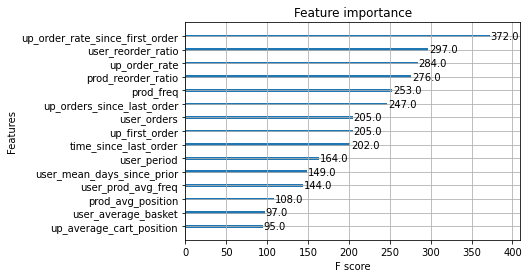

In [51]:
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
# Visualizing the Feature importance 
print(clf.feature_importances_)

xgb.plot_importance(clf)
plt.show()

## Analyzing PR-Curve 

In [52]:
# keep probabilities for the positive outcome only
y_test_prob = clf.predict_proba(X_test)[:, 1]
y_val_prob = clf.predict_proba(X_val)[:, 1]
y_train_prob = clf.predict_proba(X_train)[:, 1]

In [53]:
'''
This function maximizes a metric, while keeping another metric above a given threshold.
'''
def maximize_metric_keep_metric(metric1_list, metric2_list, metric2_thresh=0.3):
    for idx in range(len(metric1_list)):
        if(metric2_list[idx] > metric2_thresh):
            return idx
    return -1

In [55]:
from sklearn.metrics import precision_recall_curve

# Choosing Threshold that maximizes the f1_score
precision, recall, thresholds = precision_recall_curve(y_val, y_val_prob)
f1_scores = 2*recall*precision/(recall+precision)
opt_indx = np.argmax(f1_scores)
print("Maximuim f1_score for the positive class: ", f1_scores[opt_indx])
print("Correspoding precision: ", precision[opt_indx])
print("Correspoding recall: ", recall[opt_indx])
print("Correspoding Threshold: ", thresholds[opt_indx])
best_thresh = thresholds[opt_indx]

Maximuim f1_score for the positive class:  0.4400228151792239
Correspoding precision:  0.395227162841929
Correspoding recall:  0.496270922037142
Correspoding Threshold:  0.21708147


In [56]:
# Choosing Threshold that maximizes recall, while keeping precision above 0.3
opt_indx = maximize_metric_keep_metric(metric1_list=recall, metric2_list=precision, metric2_thresh=0.3)
print("Max recall for the positive class: ", recall[opt_indx])
print("Correspoding precision: ", precision[opt_indx])
print("Correspoding f1_score: ", f1_scores[opt_indx])
print("Correspoding Threshold: ", thresholds[opt_indx])
best_thresh = thresholds[opt_indx]

Max recall for the positive class:  0.6547175349085924
Correspoding precision:  0.30000036845576505
Correspoding f1_score:  0.4114629065085588
Correspoding Threshold:  0.13529855


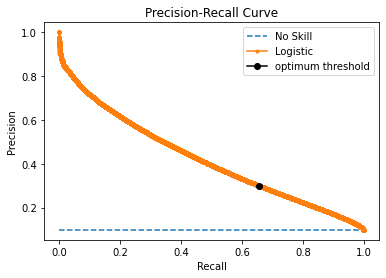

In [58]:
# plot the precision-recall curves
no_skill = len(y_val[y_val==1]) / len(y_val)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Logistic')
plt.plot(recall[opt_indx], precision[opt_indx], marker='o', color='k', label='optimum threshold')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
# show the legend
plt.legend()
# show the plot
plt.show()

In [59]:
# Changing probabilities to crisp predicted values, useing the threshold obtained from the ROC-curve
y_test_preds = y_test_prob>best_thresh
y_val_preds = y_val_prob>best_thresh
y_train_preds = y_train_prob>best_thresh

## Classification Report

In [60]:
from sklearn.metrics import confusion_matrix, classification_report

print('-----------------CLASSIFICATION REPORT--------------------')
print("Train positive class count: ", y_train.sum())
print("Train negative class count: ", y_train.shape[0] - y_train.sum())
print("Train Set tn, fp, fn, tp:",confusion_matrix(y_train, y_train_preds).ravel())
print("Train Set report:",classification_report(y_train, y_train_preds))

print("Validation positive class count: ", y_val.sum())
print("Validation negative class count: ", y_val.shape[0] - y_val.sum())
print("Validation Set tn, fp, fn, tp:",confusion_matrix(y_val, y_val_preds).ravel())
print("Validation Set report:",classification_report(y_val, y_val_preds))

-----------------CLASSIFICATION REPORT--------------------
Train positive class count:  580103.0
Train negative class count:  5352159.0
Train Set tn, fp, fn, tp: [4465892  886267  199556  380547]
Train Set report:               precision    recall  f1-score   support

         0.0       0.96      0.83      0.89   5352159
         1.0       0.30      0.66      0.41    580103

    accuracy                           0.82   5932262
   macro avg       0.63      0.75      0.65   5932262
weighted avg       0.89      0.82      0.84   5932262

Validation positive class count:  248721.0
Validation negative class count:  2293678.0
Validation Set tn, fp, fn, tp: [1913715  379963   85879  162842]
Validation Set report:               precision    recall  f1-score   support

         0.0       0.96      0.83      0.89   2293678
         1.0       0.30      0.65      0.41    248721

    accuracy                           0.82   2542399
   macro avg       0.63      0.74      0.65   2542399
weighted avg

> * By forming the X, and y in this way, data is sparse. It's very skewed to the negative class. Thus accuracy is not a good measure for how the model is performing.
> * First, we've found that there's alot of false negatives, so we considered to decrease it, or increase the recall of the positive class.
> * This means, we want to reduce the number of products the model say user won't predict in the future while he/she will actually does. On the other side, it's okay to allow some false positives, when the model recommends a products the user won't buy in the next order.
> * Our aim is to change the threshold to maximize the recall, while keeping the precision above a certain threshold. 
> * Since skewed class distribution we will consider PR-curve not ROC-curve.

#### Preparing the sumission file

In [ ]:
import csv

# Append prediction to test_order details
test_orders = X_test_non_pred_vars[['order_id','product_id']]
test_orders['reordered'] = y_test_preds

# Extracting orders who have no predicted products
empty_orders = test_orders.groupby(['order_id']).agg(
    count_reorders = ('reordered', 'sum')
).reset_index()
empty_orders = empty_orders[empty_orders['count_reorders'] == 0]

# For orders who have predicted products 
# Extract the products predicted to be in the future order
test_orders = test_orders[test_orders['reordered'] == 1]
# For each order group its predicted products together into a list 
test_orders = test_orders.groupby('order_id')['product_id'].apply(list).reset_index(name='products')


test_orders.head()

In [ ]:
# csv header
headerNames = ['order_id', 'products']
rows = []

for index, row in test_orders.iterrows():
    products = ' '.join(str(product_id) for product_id in row['products']) 
    rows.append( 
        {'order_id': str(row['order_id']),
        'products': products})

for index, row in empty_orders.iterrows():
    rows.append( 
        {'order_id': str(row['order_id']),
        'products': 'None'})
    
with open('./submissions.csv', 'w', encoding='UTF-8', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=headerNames)
    writer.writeheader()
    writer.writerows(rows)